In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg as la
import csv

import random
import numpy.random as npr
%matplotlib inline


1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [69]:
# generating dataset

N = 1000

mean_1 = 0
std_1 = 1

mean_2 = 0
std_2 = 3

# column 1 
x1 = np.random.normal(loc = mean_1, scale = std_1, size = N)
# column 2 
x2 = x1 + np.random.normal(loc = mean_2, scale = std_2, size = N)
# column 3 
x3 = 2 * x1 + x2

x = np.array([x1, x2, x3])

# Converting dataset to a pandas data frame 

data_frame = pd.DataFrame(x1, columns = ['x1'])
data_frame['x2'] = data_frame['x1'] + x2
data_frame['x3'] = x1 + x2

print('\nDataset:\n')
display(data_frame)



Dataset:



,x1,x2,x3
0,2.559150,6.836617,6.836617
1,0.014275,-1.299927,-1.299927
2,-0.557809,-1.277367,-1.277367
3,2.043017,6.908866,6.908866
4,-0.483013,-3.975468,-3.975468
...,...,...,...
995,0.727483,1.189551,1.189551
996,-0.921592,-3.363410,-3.363410
997,-1.754473,-7.028855,-7.028855
998,-1.134223,-4.072089,-4.072089


In [70]:
# finding the covariance matrix

covariance_matrix = np.cov(x)

print('The covariance matrix is:\n\n', covariance_matrix)


# finding the eigenvectors and eigenvalues

l, V = la.eig(covariance_matrix)

print('\n\nThe eigenvalues of the covariance matrix are:\n\n', l)
print('\n\nThe eigenvectors of the covariance matrix are:\n\n', V)

The covariance matrix is:

 [[ 0.96631434  1.02472921  2.95735789]
 [ 1.02472921 10.57380352 12.62326193]
 [ 2.95735789 12.62326193 18.53797771]]


The eigenvalues of the covariance matrix are:

 [ 2.81221541e+01+0.j -5.25889904e-16+0.j  1.95594151e+00+0.j]


The eigenvectors of the covariance matrix are:

 [[-0.10960368 -0.81649658  0.56685127]
 [-0.58464451 -0.40824829 -0.70108782]
 [-0.80385187  0.40824829  0.43261473]]


In [71]:
# finding the eigenvectors and eigenvalues using SVD

U, spectrum, Vt = la.svd(covariance_matrix)

print('\nThe neigenvalues with SVD:\n\n', spectrum)
print('\n\nThe eigenvectors with SVD:\n\n', U)

print('\n\nSame result for eigenvalues:',np.allclose(l, spectrum),'\nSame result for eigenvectors:',np.allclose(V, U))
print('\nThey are printed out in a different result as: \nThe first eigenvectors and eigenvalues are the same, \
but the second and the third eigenvectors and eigenvalues are changed, since they are created almost from the first.')



The neigenvalues with SVD:

 [2.81221541e+01 1.95594151e+00 1.54580444e-15]


The eigenvectors with SVD:

 [[-0.10960368  0.56685127 -0.81649658]
 [-0.58464451 -0.70108782 -0.40824829]
 [-0.80385187  0.43261473  0.40824829]]


Same result for eigenvalues: False 
Same result for eigenvectors: False

They are printed out in a different result as: 
The first eigenvectors and eigenvalues are the same, but the second and the third eigenvectors and eigenvalues are changed, since they are created almost from the first.


In [72]:
# PCA
# What percent of the total dataset's variability is explained by the principal components? 
# Given how the dataset was constructed, do these make sense? 

Lambda = np.diag(l)
print (Lambda)

percentage_00 = Lambda[0,0] / Lambda.trace()* 100
percentage_0 = round(percentage_00, 2)
percentage_11 = Lambda[1,1] / Lambda.trace()* 100
percentage_1 = round(percentage_11, 2)
percentage_22 = Lambda[2,2] / Lambda.trace()* 100
percentage_2 = round(percentage_22, 2)

print ('\nVariability for the first eigenvalue is:', np.real(percentage_0),'%')
print ('\nVariability for the second eigenvalue is:', np.real(percentage_1),'%')
print ('\nVariability for the third eigenvalue is:', np.real(percentage_2),'%')

# by looking at the Variability for each eigenvalue, it is obvious that the two biggest components are in [0,0], and [2,2]

print('\nThe first three eigenvalue have a variability \
of:',((Lambda[0,0] + Lambda[1,1] + Lambda[2,2])/Lambda.trace())*100,'%')
print('\nThe result makes sense since the most of the variability is asociated with x1, \
almost arount 93%, the only fully independant variable. However, x2 has built up by adding\
 "new information" to the second normal distribution and x3 can be totally recovered from x1 and x2 by construction.')


# Redefining the data in the basis yielded by the PCA procedure

y = np.dot(V.T, x)
new_dataframe = pd.DataFrame(np.dot(data_frame, U.T), columns=['y1','y2','y3'])
print('\n\nNew Dataset:\n')
display(new_dataframe)


[[ 2.81221541e+01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -5.25889904e-16+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  1.95594151e+00+0.j]]

Variability for the first eigenvalue is: 93.5 %

Variability for the second eigenvalue is: -0.0 %

Variability for the third eigenvalue is: 6.5 %

The first three eigenvalue have a variability of: (99.99999999999999+0j) %

The result makes sense since the most of the variability is asociated with x1, almost arount 93%, the only fully independant variable. However, x2 has built up by adding "new information" to the second normal distribution and x3 can be totally recovered from x1 and x2 by construction.


New Dataset:



<ipython-input-72-638209907940>:9: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  percentage_0 = round(percentage_00, 2)
<ipython-input-72-638209907940>:11: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  percentage_1 = round(percentage_11, 2)
<ipython-input-72-638209907940>:13: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  percentage_2 = round(percentage_22, 2)


,y1,y2,y3
0,-1.987222,-9.080299,3.691480
1,0.322956,1.433710,-1.104535
2,0.380027,1.743150,-0.625696
3,-1.948688,-8.858693,4.167127
4,1.045397,4.692521,-2.954552
...,...,...,...
995,-0.376701,-1.744931,0.415461
996,0.940669,4.269956,-2.087344
997,1.947017,8.823106,-4.499967
998,1.140893,5.180433,-2.512321


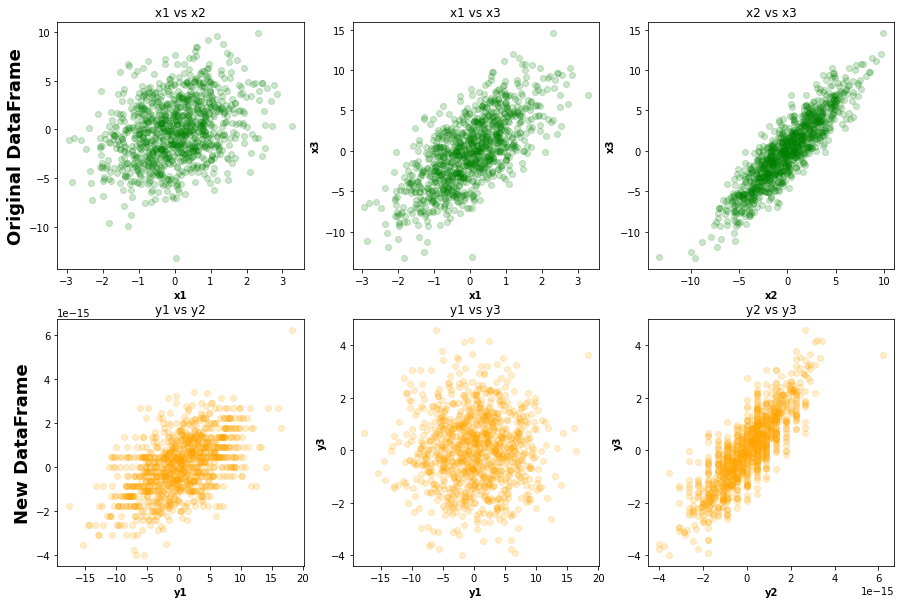

In [73]:

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))
scale_factor = 0.1

# Ploting the scatter plots in the original coordinate

axes[0,0].scatter(x[0,:], x[1,:], alpha = 0.2, color='green')
axes[0,0].set_title('x1 vs x2')
axes[0,0].set_ylabel('x2', fontweight = 'bold')
axes[0,0].set_xlabel('x1', fontweight = 'bold')
axes[0,0].set_ylabel('Original DataFrame', fontsize = 18)

axes[0,1].scatter(x[0,:], x[2,:], alpha = 0.2, color = 'green')
axes[0,1].set_title('x1 vs x3')
axes[0,1].set_ylabel('x3', fontweight = 'bold')
axes[0,1].set_xlabel('x1', fontweight = 'bold')

axes[0,2].scatter(x[1,:], x[2,:], alpha = 0.2, color = 'green')
axes[0,2].set_title('x2 vs x3')
axes[0,2].set_ylabel('x3', fontweight = 'bold')
axes[0,2].set_xlabel('x2', fontweight = 'bold')


# Ploting the scatter plots in the new coordinate

axes[1,0].scatter(y[0,:], y[1,:], alpha = 0.2, color = 'orange')
axes[1,0].set_title('y1 vs y2')
axes[1,0].set_ylabel('y2', fontweight = 'bold')
axes[1,0].set_xlabel('y1', fontweight = 'bold')
axes[1,0].set_ylabel('New DataFrame', fontsize = 18)

axes[1,1].scatter(y[0,:], y[2,:], alpha = 0.2, color = 'orange')
axes[1,1].set_title('y1 vs y3')
axes[1,1].set_ylabel('y3', fontweight = 'bold')
axes[1,1].set_xlabel('y1', fontweight = 'bold')

axes[1,2].scatter(y[1,:], y[2,:], alpha = 0.2, color = 'orange')
axes[1,2].set_title('y2 vs y3')
axes[1,2].set_ylabel('y3', fontweight = 'bold')
axes[1,2].set_xlabel('y2', fontweight = 'bold')

plt.show()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [74]:
n = 10
std = 1/50

print('\n\nOld Dataset with 3 variables:\n')
display(data_frame)

# generating new daraset with 13 variables

data_frame_2 = data_frame.copy()

data_frame_2['x4'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x5'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x6'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x7'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x8'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x9'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x10'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x11'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x12'] = (np.random.normal(loc = 0, scale = std, size = N))
data_frame_2['x13'] = (np.random.normal(loc = 0, scale = std, size = N))

print('\n\nNew Dataset with 13 variables:\n')
display(data_frame_2)

# generating an uncorrelated random noise
random_noise = np.zeros(N)
for i in range(n):
     random_noise += np.random.randn(N)/7

# adding the random noise in the new dataset with 13 variables 

data_frame_with_noise = data_frame_2.copy()

x1 = data_frame_with_noise['x1'] + random_noise
x2 = data_frame_with_noise['x2'] + random_noise
x3 = data_frame_with_noise['x3'] + random_noise
x4 = data_frame_with_noise['x4'] + random_noise
x5 = data_frame_with_noise['x5'] + random_noise
x6 = data_frame_with_noise['x6'] + random_noise
x7 = data_frame_with_noise['x7'] + random_noise
x8 = data_frame_with_noise['x8'] + random_noise
x9 = data_frame_with_noise['x9'] + random_noise
x10 = data_frame_with_noise['x10'] + random_noise
x11 = data_frame_with_noise['x11'] + random_noise
x12 = data_frame_with_noise['x12'] + random_noise
x13 = data_frame_with_noise['x13'] + random_noise

print('\n\nNew Dataset with noise:\n')
display(data_frame_with_noise)

x_new = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13])





Old Dataset with 3 variables:



,x1,x2,x3
0,2.559150,6.836617,6.836617
1,0.014275,-1.299927,-1.299927
2,-0.557809,-1.277367,-1.277367
3,2.043017,6.908866,6.908866
4,-0.483013,-3.975468,-3.975468
...,...,...,...
995,0.727483,1.189551,1.189551
996,-0.921592,-3.363410,-3.363410
997,-1.754473,-7.028855,-7.028855
998,-1.134223,-4.072089,-4.072089




New Dataset with 13 variables:



,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,2.559150,6.836617,6.836617,-0.020703,-0.013665,-0.020249,0.017092,0.034158,-0.000499,-0.029956,-0.003198,0.003497,0.015210
1,0.014275,-1.299927,-1.299927,0.015027,0.003538,0.012579,-0.008198,0.002219,-0.001273,-0.035377,-0.026979,0.000898,-0.002737
2,-0.557809,-1.277367,-1.277367,-0.010903,0.017025,0.014952,-0.002835,-0.018658,-0.003029,0.006865,-0.008538,0.015588,-0.004971
3,2.043017,6.908866,6.908866,-0.002914,0.005769,-0.010912,0.023519,0.000580,-0.013209,-0.026165,0.011369,0.001581,0.001075
4,-0.483013,-3.975468,-3.975468,0.004826,-0.024333,0.022156,0.052365,0.005039,0.030895,0.012984,0.073286,-0.008662,0.025791
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.727483,1.189551,1.189551,-0.012560,0.015447,0.033242,0.019134,-0.023459,0.017472,-0.002480,0.004982,0.027831,-0.017192
996,-0.921592,-3.363410,-3.363410,0.006419,-0.001755,-0.011736,0.034448,-0.018018,0.005374,-0.006159,0.002778,0.014222,-0.002839
997,-1.754473,-7.028855,-7.028855,0.007659,0.025455,0.013298,-0.018485,-0.037232,-0.006868,-0.021054,0.028697,0.032436,-0.030000
998,-1.134223,-4.072089,-4.072089,-0.004431,0.012307,0.012576,0.011956,0.023969,-0.022388,-0.024603,0.011105,-0.015171,-0.030494




New Dataset with noise:



,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,2.559150,6.836617,6.836617,-0.020703,-0.013665,-0.020249,0.017092,0.034158,-0.000499,-0.029956,-0.003198,0.003497,0.015210
1,0.014275,-1.299927,-1.299927,0.015027,0.003538,0.012579,-0.008198,0.002219,-0.001273,-0.035377,-0.026979,0.000898,-0.002737
2,-0.557809,-1.277367,-1.277367,-0.010903,0.017025,0.014952,-0.002835,-0.018658,-0.003029,0.006865,-0.008538,0.015588,-0.004971
3,2.043017,6.908866,6.908866,-0.002914,0.005769,-0.010912,0.023519,0.000580,-0.013209,-0.026165,0.011369,0.001581,0.001075
4,-0.483013,-3.975468,-3.975468,0.004826,-0.024333,0.022156,0.052365,0.005039,0.030895,0.012984,0.073286,-0.008662,0.025791
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.727483,1.189551,1.189551,-0.012560,0.015447,0.033242,0.019134,-0.023459,0.017472,-0.002480,0.004982,0.027831,-0.017192
996,-0.921592,-3.363410,-3.363410,0.006419,-0.001755,-0.011736,0.034448,-0.018018,0.005374,-0.006159,0.002778,0.014222,-0.002839
997,-1.754473,-7.028855,-7.028855,0.007659,0.025455,0.013298,-0.018485,-0.037232,-0.006868,-0.021054,0.028697,0.032436,-0.030000
998,-1.134223,-4.072089,-4.072089,-0.004431,0.012307,0.012576,0.011956,0.023969,-0.022388,-0.024603,0.011105,-0.015171,-0.030494


In [75]:
# The PCA procedure

# finding the covariance matrix

covariance_matrix_new = np.cov(x_new)

print('The new covariance matrix is:\n\n', covariance_matrix)


# finding the eigenvectors and eigenvalues

l_new, V_new = la.eig(covariance_matrix_new)

print('\nThe new eigenvalues of the new covariance matrix are:\n\n', l_new)
print('\nThe new eigenvectors of the new covariance matrix are:\n\n', V_new)


# finding the eigenvectors and eigenvalues using SVD

U_new, spectrum_new, Vt_new = la.svd(covariance_matrix_new)

print('\nThe new neigenvalues with SVD:\n\n', spectrum_new)
print('\nThe new eigenvectors with SVD:\n\n', U_new)

print('\nSame new result for eigenvalues:',np.allclose(l_new, spectrum_new),'\nSame new result for eigenvectors: ,\
', np.allclose(V_new, U_new))
print('\nThe new "information" of the dataset consist some uncorrelated random noises which directly affected on the ,\
eigenvalues. Consequently, the lowest eigenvalues are now much higher than before.')

The new covariance matrix is:

 [[ 0.96631434  1.02472921  2.95735789]
 [ 1.02472921 10.57380352 12.62326193]
 [ 2.95735789 12.62326193 18.53797771]]

The new eigenvalues of the new covariance matrix are:

 [2.76930315e+01+0.j 2.28513319e+00+0.j 5.94203725e-01+0.j
 3.42381811e-04+0.j 3.59643156e-04+0.j 3.84005847e-04+0.j
 3.97452378e-04+0.j 4.07555836e-04+0.j 4.53495939e-04+0.j
 4.26783089e-04+0.j 4.44446234e-04+0.j 4.43867536e-04+0.j
 4.73631533e-17+0.j]

The new eigenvectors of the new covariance matrix are:

 [[ 1.14004091e-01  3.76841969e-01  9.19232357e-01 -9.21004898e-05
   5.69927884e-04  1.22820483e-03 -1.13328600e-03 -1.35862082e-04
  -8.55274674e-04 -2.10439746e-05  1.07525143e-03  1.96216852e-04
  -2.95313170e-16]
 [ 7.02229974e-01 -4.85895581e-02 -6.71712337e-02  1.71037355e-04
  -7.45532209e-05 -2.72346324e-04  8.13942808e-06  1.69526356e-05
   1.53089839e-04  9.07005337e-05  1.38345047e-05 -5.69450365e-05
  -7.07106781e-01]
 [ 7.02229974e-01 -4.85895581e-02 -6.71712337e-0

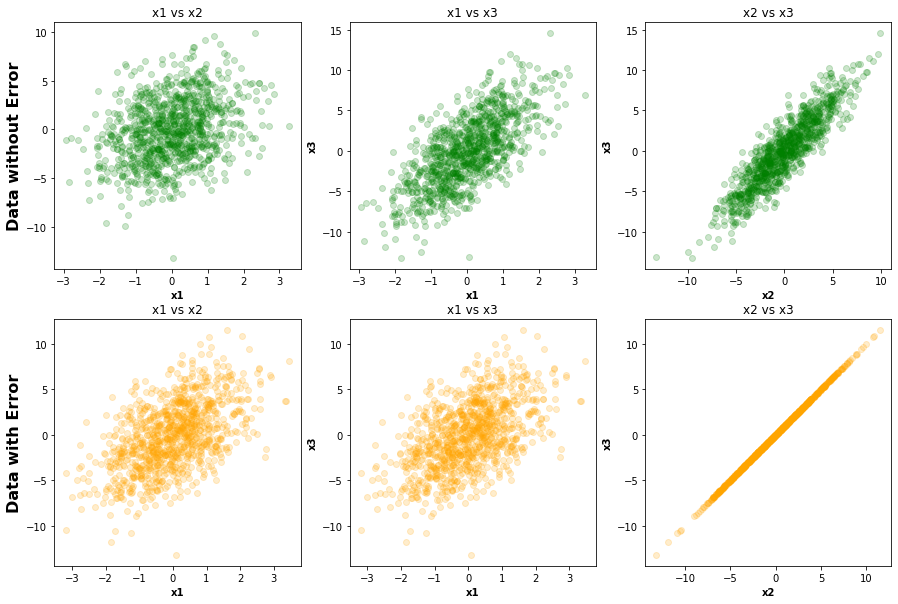

In [76]:

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))
scale_factor = 0.1

# Ploting the scatter plots of the original dataset withouth error

axes[0,0].scatter(x[0,:], x[1,:], alpha = 0.2, color='green')
axes[0,0].set_title('x1 vs x2')
axes[0,0].set_ylabel('x2',fontweight='bold')
axes[0,0].set_xlabel('x1',fontweight='bold')
axes[0,0].set_ylabel('Data without Error', fontsize = 16)

axes[0,1].scatter(x[0,:], x[2,:], alpha = 0.2, color='green')
axes[0,1].set_title('x1 vs x3')
axes[0,1].set_ylabel('x3', fontweight = 'bold')
axes[0,1].set_xlabel('x1', fontweight = 'bold')

axes[0,2].scatter(x[1,:], x[2,:], alpha = 0.2, color='green')
axes[0,2].set_title('x2 vs x3')
axes[0,2].set_ylabel('x3', fontweight = 'bold')
axes[0,2].set_xlabel('x2', fontweight = 'bold')


# Ploting the scatter plots of dataset with error

axes[1,0].scatter(x_new[0,:], x_new[1,:], alpha = 0.2, color='orange')
axes[1,0].set_title('x1 vs x2')
axes[1,0].set_ylabel('x2',fontweight='bold')
axes[1,0].set_xlabel('x1',fontweight='bold')
axes[1,0].set_ylabel('Data with Error', fontsize = 16)

axes[1,1].scatter(x_new[0,:], x_new[2,:], alpha = 0.2, color='orange')
axes[1,1].set_title('x1 vs x3')
axes[1,1].set_ylabel('x3',fontweight='bold')
axes[1,1].set_xlabel('x1',fontweight='bold')

axes[1,2].scatter(x_new[1,:], x_new[2,:], alpha = 0.2, color='orange')
axes[1,2].set_title('x2 vs x3')
axes[1,2].set_ylabel('x3',fontweight='bold')
axes[1,2].set_xlabel('x2',fontweight='bold')

plt.show()

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

In [118]:
# import and show data

magic_data = pd.read_csv('D:/G/Books/Geophysics/Padova University/Semester 3/HIGH LEVEL PROGRAMMING/Data/magic04.data', header = None, usecols=np.r_[0:10])
print('\nThe magic dataset:\n'); display(magic_data)

transposed_magic_data = magic_data.T
print('\nThe transposed magic dataset:\n'); display(transposed_magic_data)

old_dataset = transposed_magic_data.to_numpy()


The magic dataset:



,0,1,2,3,4,5,6,7,8,9
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620
...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166



The transposed magic dataset:



,0,1,2,3,4,5,6,7,8,9,...,19010,19011,19012,19013,19014,19015,19016,19017,19018,19019
0,28.7967,31.6036,162.0520,23.8172,75.1362,51.6240,48.2468,26.7897,96.2327,46.7619,...,32.4902,79.5528,31.8373,182.5003,43.2980,21.3846,28.9452,75.4455,120.5135,187.1814
1,16.0021,11.7235,136.0310,9.5728,30.9205,21.1502,17.3565,13.7595,46.5165,15.1993,...,10.6723,44.9929,13.8734,76.5568,17.3545,10.9170,6.7020,47.5305,76.9018,53.0014
2,2.6449,2.5185,4.0612,2.3385,3.1611,2.9085,3.0332,2.5521,4.1540,2.5786,...,2.4742,3.5488,2.8251,3.6872,2.8307,2.6161,2.2672,3.4483,3.9939,3.2093
3,0.3918,0.5303,0.0374,0.6147,0.3168,0.2420,0.2529,0.4236,0.0779,0.3377,...,0.4664,0.1656,0.4169,0.1123,0.2877,0.5857,0.5351,0.1417,0.0944,0.2876
4,0.1982,0.3773,0.0187,0.3922,0.1832,0.1340,0.1515,0.2174,0.0390,0.1913,...,0.2735,0.0900,0.1988,0.0666,0.1646,0.3934,0.2784,0.0549,0.0683,0.1539
5,27.7004,26.2722,116.7410,27.2107,-5.5277,50.8761,8.5730,29.6339,110.3550,24.7548,...,-27.0097,-39.6213,-16.4919,192.2675,-60.1842,15.2618,37.0816,-9.3561,5.8043,-167.3125
6,22.0110,23.8238,-64.8580,-6.4633,28.5525,43.1887,38.0957,20.4560,85.0486,43.8771,...,-21.1687,53.7866,-27.1448,93.0302,-33.8513,11.5245,13.1853,41.0562,-93.5224,-168.4558
7,-8.2027,-9.9574,-45.2160,-7.1513,21.8393,9.8145,10.5868,-2.9292,43.1844,-6.6812,...,8.4813,-30.0054,11.1098,-62.6192,-3.6545,2.8766,-2.9632,-9.4662,-63.8389,31.4755
8,40.0920,6.3609,76.9600,10.4490,4.6480,3.6130,4.7920,0.8120,4.8540,7.8750,...,69.1730,15.8075,11.3663,82.1691,78.4099,2.4229,86.7975,30.2987,84.6874,52.7310
9,81.8828,205.2610,256.7880,116.7370,356.4620,238.0980,219.0870,237.1340,248.2260,102.2510,...,120.6680,311.5680,100.0566,283.4731,224.8299,106.8258,247.4560,256.5166,408.3166,272.3174


In [78]:
# finding the covariance matrix

magic_covariance_matrix = np.cov(transposed_magic_data)

print('\nThe covariance matrix of magic dataset is: \n\n', magic_covariance_matrix)

# finding the eigenvectors and eigenvalues of the covariance matrix

l, V = la.eig(magic_covariance_matrix)

print ('\nThe eigenvalues of the covariance matrix are: \n\n', l)
print ('\nThe eigenvectors of the covariance matrix are: \n\n', V)


The covariance matrix of magic dataset is: 

 [[ 1.79478093e+03  5.98863542e+02  1.40642293e+01 -4.88699477e+00
  -2.80038030e+00 -9.24434103e+02 -2.58727155e+02  1.18140078e+01
  -9.70681761e+00  1.32486413e+03]
 [ 5.98863542e+02  3.36577782e+02  6.22110176e+00 -2.04513685e+00
  -1.17822641e+00 -2.89972346e+02 -1.64893734e+02  1.51860869e+01
   3.16366938e+01  4.61786200e+02]
 [ 1.40642293e+01  6.22110176e+00  2.23349483e-01 -7.35110795e-02
  -4.22432318e-02 -4.47307815e+00  2.29353454e+00  1.52121337e-01
  -2.30292484e+00  1.54354673e+01]
 [-4.88699477e+00 -2.04513685e+00 -7.35110795e-02  3.34206468e-02
   1.97262797e-02  1.21519489e+00 -1.13652751e+00 -4.30025009e-02
   1.12273751e+00 -4.48566053e+00]
 [-2.80038030e+00 -1.17822641e+00 -4.22432318e-02  1.97262797e-02
   1.22126367e-02  6.55332684e-01 -6.69389146e-01 -2.52390547e-02
   6.62907179e-01 -2.51579453e+00]
 [-9.24434103e+02 -2.89972346e+02 -4.47307815e+00  1.21519489e+00
   6.55332684e-01  3.50535778e+03  8.27482747e+02  3

In [79]:
# SVD decomposition

U, spectrum, Vt = la.svd(magic_covariance_matrix)

print('\nThe neigenvalues with SVD: \n\n', spectrum)
print('\nThe eigenvectors with SVD: \n\n', U)

print('\nSame result for eigenvalues:',np.allclose(l, spectrum),'\nSame result for eigenvectors:',np.allclose(V, U))


The neigenvalues with SVD: 

 [6.57979140e+03 3.85387048e+03 2.01638313e+03 1.32675968e+03
 6.10187259e+02 4.33599171e+02 1.17330074e+02 8.63965822e-02
 1.07363851e-02 3.85322859e-04]

The eigenvectors with SVD: 

 [[-3.27812305e-01 -1.34406332e-01 -6.55078481e-02 -8.63988253e-01
  -9.45511967e-02 -1.98552026e-02 -3.38166662e-01  3.99907112e-03
  -4.54836725e-04 -4.57080123e-05]
 [-1.13810001e-01 -5.38837224e-02  1.89938175e-02 -3.19766485e-01
   1.97548493e-02  2.32592322e-02  9.38307839e-01  1.33847863e-02
   6.74902809e-04  5.73158422e-05]
 [-3.06076690e-03  6.59372017e-04 -1.05931761e-03 -6.93028658e-03
  -2.65185255e-03  1.33441545e-04  1.08823228e-02 -9.27765187e-01
  -3.72229862e-01 -2.26331399e-02]
 [ 9.27109146e-04 -2.58205308e-04  5.10399700e-04  2.60555110e-03
   1.53899865e-03 -3.46437681e-05 -3.06287144e-03  3.22020557e-01
  -7.69222364e-01 -5.51887659e-01]
 [ 5.21882399e-04 -1.52710005e-04  2.94635944e-04  1.51275933e-03
   9.19340567e-04 -2.21501607e-05 -1.81386903e-03 

In [101]:
Lambda = np.diag(l)
print (Lambda)

percentage_0 = Lambda[0,0] / Lambda.trace()* 100
percentage_1 = Lambda[1,1] / Lambda.trace()* 100
percentage_2 = Lambda[2,2] / Lambda.trace()* 100
percentage_3 = Lambda[3,3] / Lambda.trace()* 100
percentage_4 = Lambda[4,4] / Lambda.trace()* 100
percentage_5 = Lambda[5,5] / Lambda.trace()* 100
percentage_6 = Lambda[6:6] / Lambda.trace()* 100
percentage_7 = Lambda[7:7] / Lambda.trace()* 100
percentage_8 = Lambda[8:8] / Lambda.trace()* 100
percentage_9 = Lambda[9:9] / Lambda.trace()* 100

print ('\nVariability for the first eigenvalue is:', np.real(percentage_0),'%')
print ('\nVariability for the second eigenvalue is:', np.real(percentage_1),'%')
print ('\nVariability for the third eigenvalue is:', np.real(percentage_2),'%')
print ('\nVariability for the forth eigenvalue is:', np.real(percentage_3),'%')
print ('\nVariability for the fifth eigenvalue is:', np.real(percentage_4),'%')
print ('\nVariability for the sixth eigenvalue is:', np.real(percentage_5),'%')
print ('\nVariability for the seventh eigenvalue is:', np.real(percentage_6),'%')
print ('\nVariability for the eight eigenvalue is:', np.real(percentage_7),'%')
print ('\nVariability for the nineth eigenvalue is:', np.real(percentage_8),'%')
print ('\nVariability for the tenth eigenvalue is:', np.real(percentage_9),'%')


print('\nThe first three components have a variability of:\n\n',((Lambda[0,0]+Lambda[1,1]+Lambda[2,2])/Lambda.trace())*100,'%')
print('\nThe first six components have a variability of:\n\n',((Lambda[0,0]+Lambda[1,1]+Lambda[2,2]+Lambda[3,3]+Lambda[4,4]+Lambda[5,5])/Lambda.trace())*100,'%')

print('\nAccording to the Variability for each eigenvalue, it is obvious that the three biggest components are in [0,0], [1,1], and [2,2] with more than 83%  Variability.')


# Redefining the data in the basis yielded by the PCA procedure

V_most = V[:,:2]
new_dataset = np.dot(V_most.T, transposed_magic_data)

new_dataframe = pd.DataFrame(new_dataset)  
print('\n\nNew Dataframe:\n')
display(new_dataframe)

[[6.57979140e+03+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 3.85387048e+03+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 2.01638313e+03+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  1.32675968e+03+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 6.10187259e+02+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j]
 [0.0

,0,1,2,3,4,5,6,7,8,9,...,19010,19011,19012,19013,19014,19015,19016,19017,19018,19019
0,-66.770898,-174.588255,-243.440502,-97.933588,-331.900019,-199.676358,-198.341584,-199.693918,-200.227141,-91.215695,...,-122.857321,-307.080879,-104.96704,-225.717188,-228.95522,-92.565079,-201.476793,-247.779335,-396.071821,-372.581595
1,55.598192,109.891592,111.280406,58.003670,145.558113,148.384175,108.914137,124.540951,209.803405,75.619795,...,5.522077,115.133516,7.78972,263.281269,15.03868,56.976797,119.750120,105.154801,87.969150,-133.879729


Text(0.5, 1.0, 'Old dataset vs New dataset')

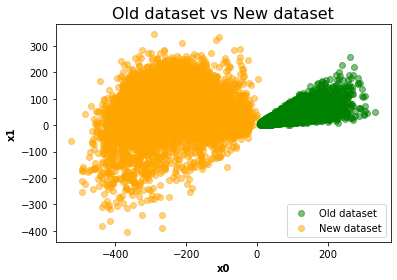

In [126]:
# scatter plot for the first two principal components 

plt.figure()
plt.scatter(old_dataset[0,:], old_dataset[1,:], alpha = 0.5, color='green', label='Old dataset')
plt.scatter(new_dataset[0,:], new_dataset[1,:], alpha = 0.5, color='orange', label='New dataset')
plt.legend()
plt.xlabel('x0',fontweight='bold')
plt.ylabel('x1',fontweight='bold')
plt.title('Old dataset vs New dataset', fontsize = 16)